In [1]:
import torch

import torch.nn as nn

import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split

In [2]:
# Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

In [3]:
# 1. Generate Dataset

X,y = make_moons(n_samples=1000, noise=0.2, random_state=42)

X_tensor = torch.tensor(X,dtype=torch.float32 ).to(device)

y_tensor = torch.tensor(y,dtype=torch.float32 ).unsqueeze(1).to(device)

In [4]:
# 2. Model Definition

class Lightnet(nn.Module):

    def __init__(self, init_type='xavier'):
        super(Lightnet, self).__init__()

        self.layers = nn.Sequential(

        nn.Linear(2,64),

        nn.ReLU(),

        nn.Linear(64,64),

        nn.ReLU(),

        nn.Linear(64,1)

        )

        self.init_weights(init_type)

    def init_weights(self,init_type):

        for m in self.modules():

            if isinstance(m, nn.Linear):

                if init_type == 'xavier':

                    nn.init.xavier_uniform_(m.weight)

                elif init_type == 'he':

                    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

                elif init_type == 'bad':

                    nn.init.constant_(m.weight, 0.01)

                nn.init.constant_(m.bias, 0.0)

    
    def forward(self, x):

        return self.layers(x)

In [5]:
# 3. Training Function

def train_model(model, X,y, epochs=1000, lr=0.01):

    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_log, act_log, grad_log = [], [], []


    for epoch in range(epochs):

        model.train()

        output = model(X)

        loss = criterion(output, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()



        # Save activations and gradients from last epoch

        if epoch == epochs -1:

            for name, param in model.named_parameters():

                if 'weight' in name:

                    grad_log.append(param.grad.view(-1).cpu().detach().numpy())

                    act_log.append(param.data.view(-1).cpu().detach().numpy())

        loss_log.append(loss.item())

    
    return loss_log, act_log, grad_log

In [6]:
# 4. Run Training for Each Init Type


inits = ['bad', 'xavier', 'he']

results = {}

models = {}

for init in inits:

    print(f'Training with {init.upper()} initialization....')

    model = Lightnet(init).to(device)

    loss , activations, grads = train_model(model, X_tensor, y_tensor)

    results[init] = {"loss": loss, 'activations':activations, 'grads':grads}

    models[init]= model

Training with BAD initialization....
Training with XAVIER initialization....
Training with HE initialization....


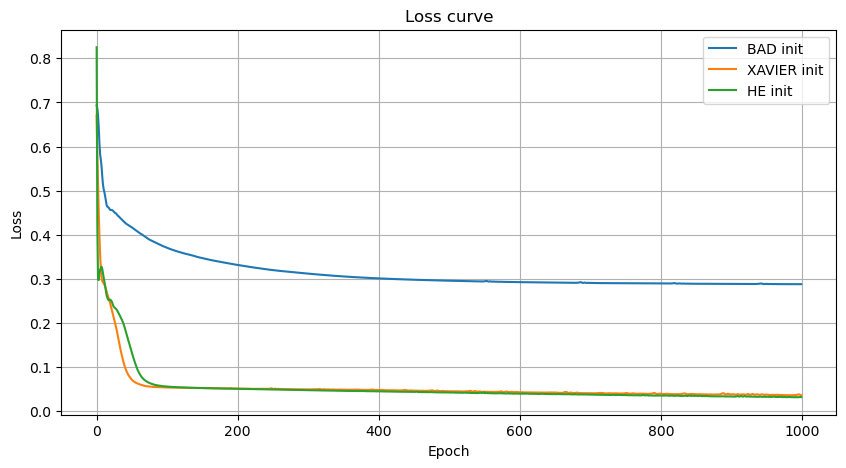

In [7]:
# 5. Plot Loss Curves

plt.figure(figsize=(10,5))

for k in results:

    plt.plot(results[k]['loss'], label = f'{k.upper()} init')

plt.title('Loss curve')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.grid(True)

plt.show()

In [8]:
for k in results:
    print(f"{k.upper()} Init Keys:", results[k].keys())


BAD Init Keys: dict_keys(['loss', 'activations', 'grads'])
XAVIER Init Keys: dict_keys(['loss', 'activations', 'grads'])
HE Init Keys: dict_keys(['loss', 'activations', 'grads'])


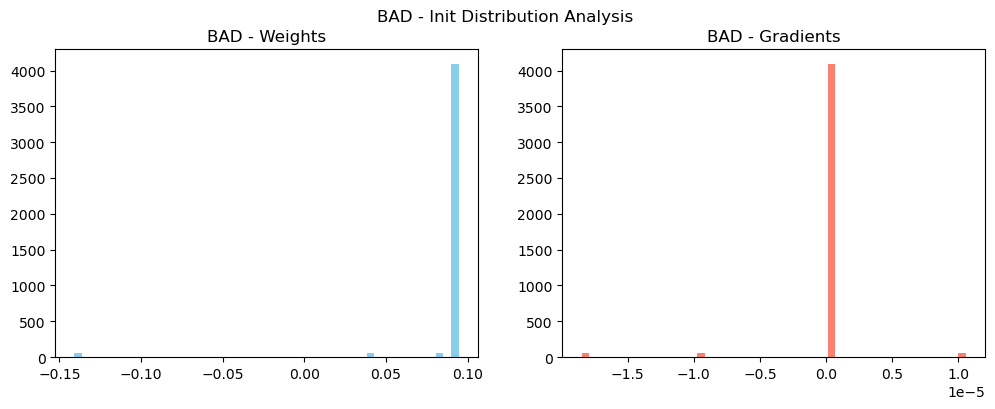

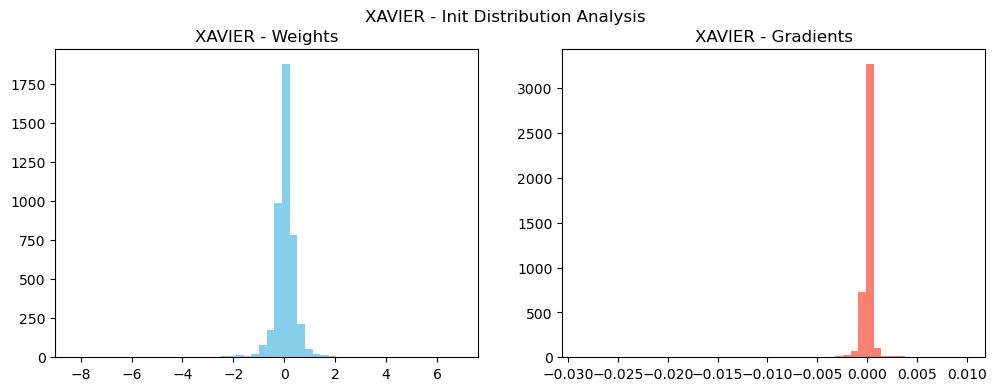

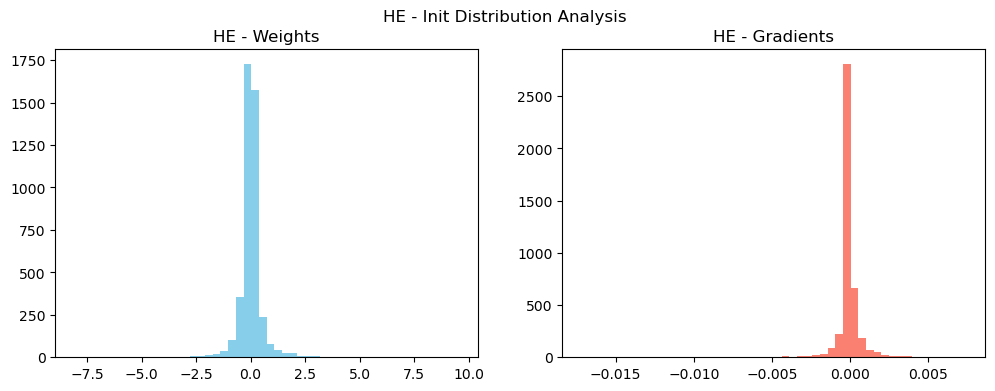

In [9]:
# 6. Plot Histograms of Weights & Gradients

for k in results:

    fig, axs = plt.subplots(1,2, figsize=(12, 4))

    axs[0].hist(torch.cat([torch.tensor(a) for a in results[k]['activations']]), bins=50, color='skyblue')

    axs[0].set_title(f'{k.upper()} - Weights')

    axs[1].hist(torch.cat([torch.tensor(g) for g in results[k]['grads']]), bins=50, color='salmon')

    axs[1].set_title(f'{k.upper()} - Gradients')

    plt.suptitle(f'{k.upper()} - Init Distribution Analysis')

    plt.show()

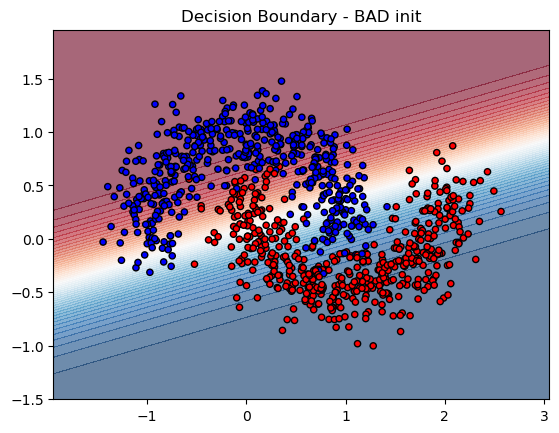

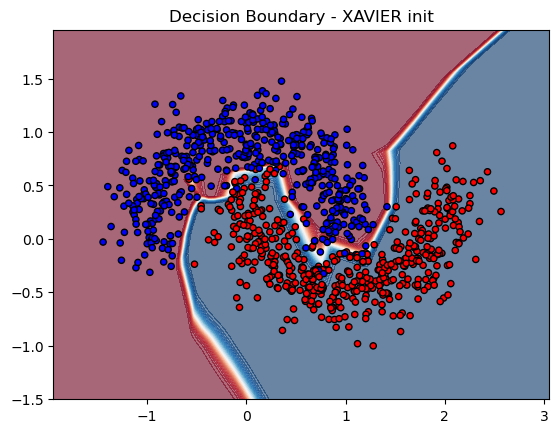

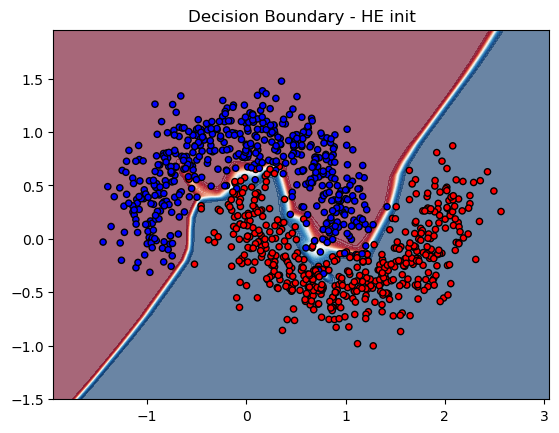

In [11]:
# 7. Decision Boundary Plotting


def plot_decision_boundary(model, X, y, title):

    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5

    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5

    xx, yy = torch.meshgrid(torch.arange(x_min,x_max, 0.02), torch.arange(y_min, y_max, 0.02), indexing='xy')

    grid = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)), dim=1).to(device)


    with torch.no_grad():

        preds = model(grid).reshape(xx.shape)

        preds = torch.sigmoid(preds)

    plt.contourf(xx.cpu(), yy.cpu(), preds.cpu(), levels=50,cmap='RdBu', alpha=0.6)
    
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolors='k', s=20)

    plt.title(title)

    plt.show()

for init in models:

    plot_decision_boundary(models[init], X, y, f'Decision Boundary - {init.upper()} init')

Loss Curve: How quickly and smoothly each initialization leads to convergence.
Histogram: Detect vanishing/exploding gradients or stuck weights.
Decision Boundary: How well the model separates classes with different inits.